In [101]:
import os, time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.utils import image_dataset_from_directory
from IPython import display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2

In [102]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [103]:
img_height, img_width = 256, 256
batch_size = 128
DATA_DIR = './cartoonset10k'

In [104]:
train_ds = image_dataset_from_directory(
  DATA_DIR,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 10000 files.


2025-09-12 10:55:54.672966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 100663296 bytes after encountering the first element of size 100663296 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


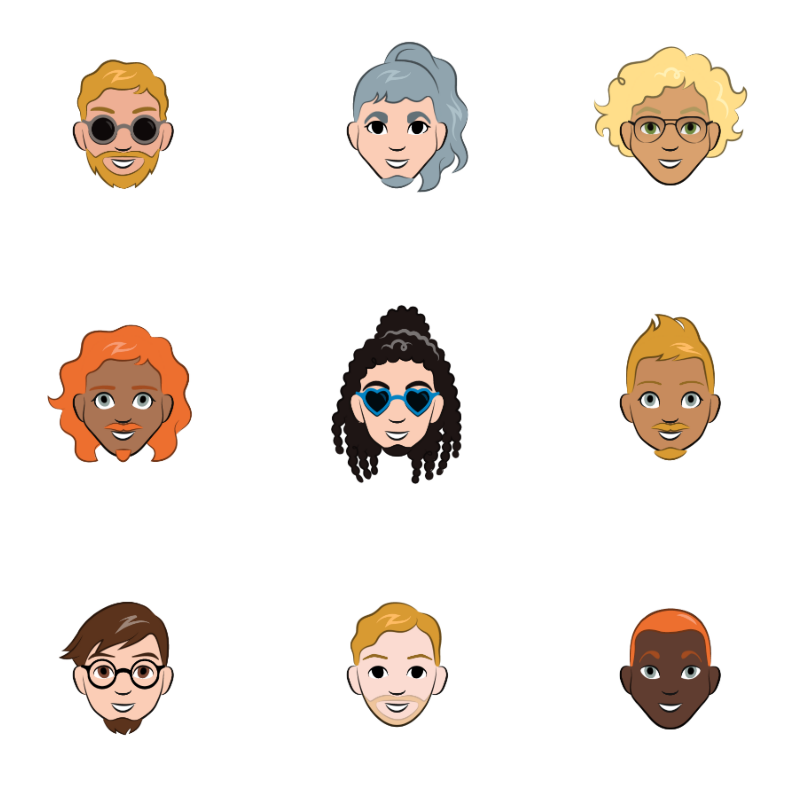

In [105]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [106]:
normalization_layer = layers.Rescaling(scale= 1./255)

In [107]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [108]:
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [109]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [110]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

In [111]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, 
                      padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, 
                      padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', 
                      name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', 
                      name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', 
                      name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [112]:
enc = encoder(input_encoder)

In [113]:
# enc.save('vae-cartoon-enc.h5')

In [114]:
enc.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 128, 128,  │        128 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lrelu_1 (LeakyReLU) │ (None, 128, 128,  │          0 │ bn_1[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 64, 64,    │     18,496 │ lrelu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 64, 64,    │        256 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lrelu_2 (LeakyReLU) │ (None, 64, 64,    │          0 │ bn_2[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 32, 32,    │     36,928 │ lrelu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 32, 32,    │        256 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lrelu_3 (LeakyReLU) │ (None, 32, 32,    │          0 │ bn_3[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 16, 16,    │     36,928 │ lrelu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_4                │ (None, 16, 16,    │        256 │ conv_4[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lrelu_4 (LeakyReLU) │ (None, 16, 16,    │          0 │ bn_4[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 8, 8, 64)  │     36,928 │ lrelu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 8, 8, 64)  │        256 │ conv_5[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lrelu_5 (LeakyReLU) │ (None, 8, 8, 64)  │          0 │ bn_5[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4096)      │          0 │ lrelu_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 200)       │    819,400 │ flatten_4[0][0] 

 Total params: 1,770,128 (6.75 MB)

 Trainable params: 1,769,552 (6.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [115]:
input_1 = (200,)
input_2 = (200,)

In [116]:
def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [117]:
final = sampling(input_1,input_2)

In [118]:
# final.save('sampling-cartoon.h5')

In [119]:
def decoder(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',
                                name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',
                                name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', 
                               name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same',
                                name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', 
                                     name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [120]:
dec = decoder(input_decoder)

In [121]:
# dec.save('vae-cartoon-dec.h5')

In [122]:
dec.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       823,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_1                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_1 (LeakyReLU)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_2                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_2 (LeakyReLU)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_3                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_3 (LeakyReLU)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_4                │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_4 (LeakyReLU)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_5                │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,307 (3.64 MB)

 Trainable params: 953,859 (3.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [123]:
#model.layers[1].get_weights()

In [124]:
#model.save('autoencoder.h5')

In [ ]:
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [ ]:
def mse_loss(y_true, y_pred):
    return 1000.0 * K.mean(K.square(y_true - y_pred), axis=[1,2,3])

def kl_loss(mean, log_var):
    return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=1)  

def vae_loss(y_true, y_pred, mean, log_var):
    return mse_loss(y_true, y_pred) + kl_loss(mean, log_var)  


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss_vec = vae_loss(images, generated_images, mean, log_var) 
        loss = tf.reduce_mean(loss_vec) 
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    decoder_optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [ ]:
os.makedirs('tf_vae/cartoon/training_weights', exist_ok=True)
os.makedirs('tf_vae/cartoon/images', exist_ok=True)

In [ ]:
def generate_and_save_images(epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('tf_vae/cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images(epoch + 1, seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights(f'tf_vae/cartoon/training_weights/enc_{epoch+1}.weights.h5')
        dec.save_weights(f'tf_vae/cartoon/training_weights/dec_{epoch+1}.weights.   h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(epoch + 1, seed)

(16, 256, 256, 3)


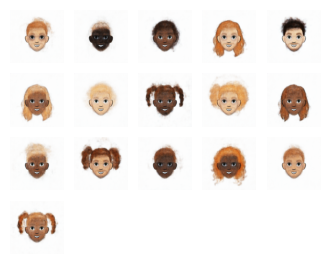

In [ ]:
train(normalized_ds, 30)

In [ ]:
# enc.load_weights('tf_vae/cartoon/training_weights/enc_29.h5')

In [ ]:
# dec.load_weights('tf_vae/cartoon/training_weights/dec_29.h5')

In [ ]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > 5000:
        break

4/4 [==============================] - 0s 802us/step


In [ ]:
embeddings.shape

(5120, 200)

## Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

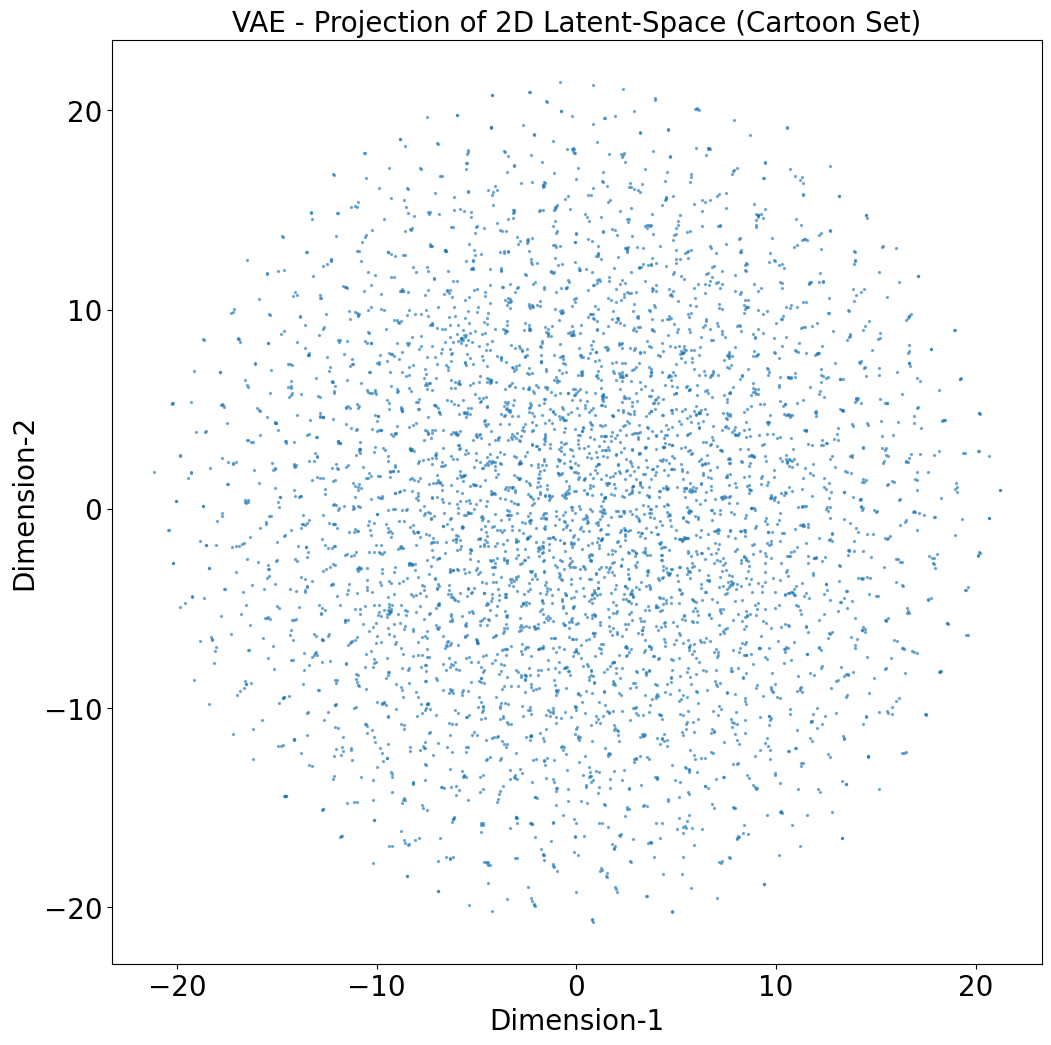

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("VAE - Projection of 2D Latent-Space (Cartoon Set)", size=20)
plt.show()

In [ ]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

4/4 [==============================] - 0s 75ms/step


In [ ]:
reconstruction.shape

(5120, 256, 256, 3)

## Reconstructing Test Images

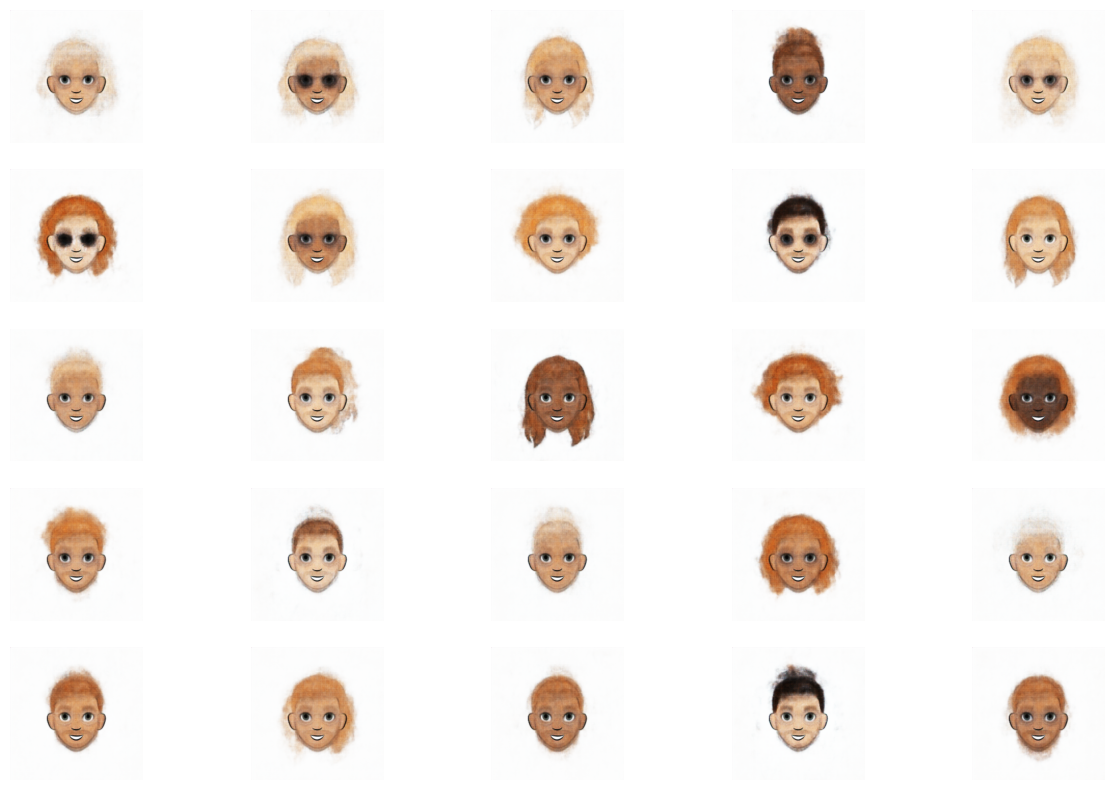

In [ ]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

## Reconstructing Cartoon Images from a Latent-Vector Sampled with Normal Distribution

1/1 [==============================] - 2s 2s/step


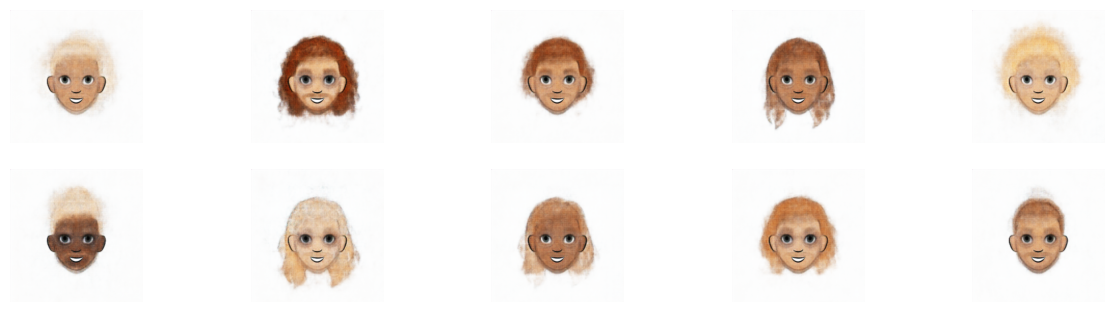

In [ ]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images with Latent-Vector Sampled Uniformly

(10, 200)
1/1 [==============================] - 0s 70ms/step


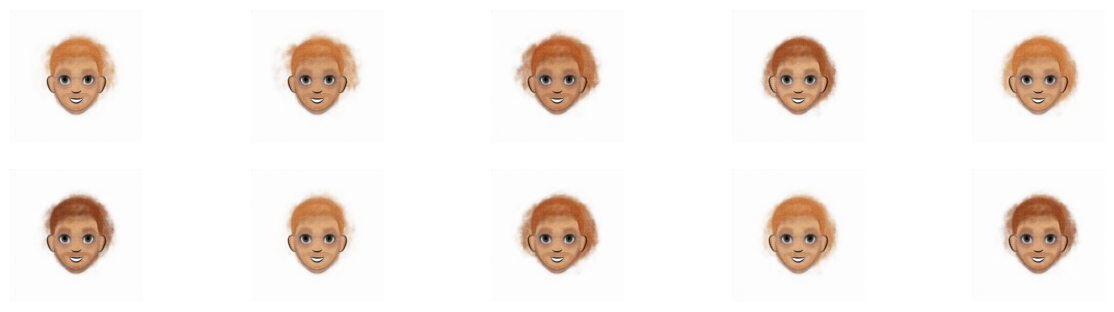

In [ ]:
figsize = 15


min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)